# 03 - Entrenamiento de Modelos para Detección de Fraude

## 🎯 Objetivos de este Notebook

En este notebook aprenderás y aplicarás:

1. **Cargar datos preprocesados** del notebook anterior
2. **Entrenar múltiples modelos** de Machine Learning
3. **Evaluar y comparar** el desempeño de cada modelo
4. **Entender métricas** apropiadas para problemas desbalanceados
5. **Seleccionar el mejor modelo** basándose en métricas de negocio

## 🤖 Modelos que entrenaremos:

- **Logistic Regression**: Modelo lineal simple y rápido
- **Random Forest**: Ensemble de árboles de decisión

In [16]:
# CELDA 1: Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [17]:
# CELDA 2: Configuración de Rutas
PROJECT_ROOT = Path.cwd().parent
DATA_PATH = PROJECT_ROOT / 'data'
PROCESSED_DATA_PATH = DATA_PATH / 'processed'
MODELS_PATH = PROJECT_ROOT / 'models'
FIGURES_PATH = PROJECT_ROOT / 'reports' / 'figures'

MODELS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

print(f"📁 Proyecto: {PROJECT_ROOT}")
print(f"📁 Modelos: {MODELS_PATH}")
print(f"📁 Figuras: {FIGURES_PATH}")

📁 Proyecto: c:\dev\repos-deep-learning\fraude-detection
📁 Modelos: c:\dev\repos-deep-learning\fraude-detection\models
📁 Figuras: c:\dev\repos-deep-learning\fraude-detection\reports\figures


In [18]:
# CELDA 3: Cargar Datos Procesados
print("="*60)
print("📂 CARGANDO DATOS PROCESADOS")
print("="*60)

X_train = pd.read_csv(PROCESSED_DATA_PATH / 'X_train_balanced.csv')
y_train = pd.read_csv(PROCESSED_DATA_PATH / 'y_train_balanced.csv')['Class']
X_val = pd.read_csv(PROCESSED_DATA_PATH / 'X_val.csv')
y_val = pd.read_csv(PROCESSED_DATA_PATH / 'y_val.csv')['Class']
X_test = pd.read_csv(PROCESSED_DATA_PATH / 'X_test.csv')
y_test = pd.read_csv(PROCESSED_DATA_PATH / 'y_test.csv')['Class']

print("\n✅ Datos cargados correctamente")
print(f"\n📊 Train: X={X_train.shape}, y={y_train.shape}")
print(f"📊 Val:   X={X_val.shape}, y={y_val.shape}")
print(f"📊 Test:  X={X_test.shape}, y={y_test.shape}")

📂 CARGANDO DATOS PROCESADOS

✅ Datos cargados correctamente

📊 Train: X=(272941, 30), y=(272941,)
📊 Val:   X=(45569, 30), y=(45569,)
📊 Test:  X=(56962, 30), y=(56962,)


## 📚 TEORÍA: Métricas para Clasificación

### ⚠️ ¿Por qué NO usamos Accuracy?

Con datos desbalanceados (99.8% legítimas), un modelo que predice "siempre legítima" tendría 99.8% accuracy pero sería inútil.

### 📊 Métricas Correctas:

**1. Precision** = TP / (TP + FP)  
→ De las alertas de fraude, ¿cuántas son correctas?

**2. Recall** = TP / (TP + FN)  
→ De todos los fraudes reales, ¿cuántos detectamos?

**3. F1-Score** = 2 × (Precision × Recall) / (Precision + Recall)  
→ Balance armónico

**4. ROC-AUC**  
→ Capacidad de distinguir entre clases

In [19]:
# CELDA 4: Función para Calcular Métricas
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name="Model"):
    print("\n" + "="*60)
    print(f"📊 MÉTRICAS - {model_name}")
    print("="*60)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"\n🎯 Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"🎯 Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"🎯 F1-Score:  {f1:.4f}")
    print(f"🎯 ROC-AUC:   {roc_auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📋 Matriz de Confusión:")
    print(f"   TN={tn:,} FP={fp:,}")
    print(f"   FN={fn:,} TP={tp:,}")
    
    return {
        'model_name': model_name,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }

print("✅ Función de métricas definida")

✅ Función de métricas definida


## 🔵 Logistic Regression

Modelo lineal que predice probabilidades usando la función sigmoide.

**Ventajas:**
- ⚡ Rápido
- 📊 Interpretable
- 💾 Ligero

**Limitaciones:**
- Solo relaciones lineales

In [20]:
# CELDA 5: Entrenar Logistic Regression
print("="*60)
print("🔵 LOGISTIC REGRESSION")
print("="*60)

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

print("\n⏳ Entrenando...")
start_time = time.time()
lr_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✅ Entrenado en {training_time:.2f}s")

y_val_pred_lr = lr_model.predict(X_val)
y_val_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]

lr_metrics = calculate_metrics(y_val, y_val_pred_lr, y_val_pred_proba_lr, "Logistic Regression")

🔵 LOGISTIC REGRESSION

⏳ Entrenando...
✅ Entrenado en 2.89s

📊 MÉTRICAS - Logistic Regression

🎯 Precision: 0.0549 (5.49%)
🎯 Recall:    0.8734 (87.34%)
🎯 F1-Score:  0.1034
🎯 ROC-AUC:   0.9689

📋 Matriz de Confusión:
   TN=44,303 FP=1,187
   FN=10 TP=69


## 🌲 Random Forest

Ensemble de muchos árboles de decisión que "votan" en conjunto.

**Ventajas:**
- 🎯 Muy preciso
- 🔀 Captura relaciones complejas
- 💪 Robusto

**Limitaciones:**
- ⏱️ Más lento
- 💾 Más memoria

In [21]:
# CELDA 6: Entrenar Random Forest
print("="*60)
print("🌲 RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

print("\n⏳ Entrenando (1-2 minutos)...")
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✅ Entrenado en {training_time:.2f}s")

y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

rf_metrics = calculate_metrics(y_val, y_val_pred_rf, y_val_pred_proba_rf, "Random Forest")

🌲 RANDOM FOREST

⏳ Entrenando (1-2 minutos)...
✅ Entrenado en 10.91s

📊 MÉTRICAS - Random Forest

🎯 Precision: 0.4923 (49.23%)
🎯 Recall:    0.8101 (81.01%)
🎯 F1-Score:  0.6124
🎯 ROC-AUC:   0.9688

📋 Matriz de Confusión:
   TN=45,424 FP=66
   FN=15 TP=64


🔍 TOP 10 FEATURES MÁS IMPORTANTES
feature  importance
    V14    0.195891
    V10    0.114710
    V12    0.104327
     V4    0.099517
    V17    0.087549
    V16    0.059174
    V11    0.055819
     V3    0.053163
     V2    0.041570
     V9    0.028225


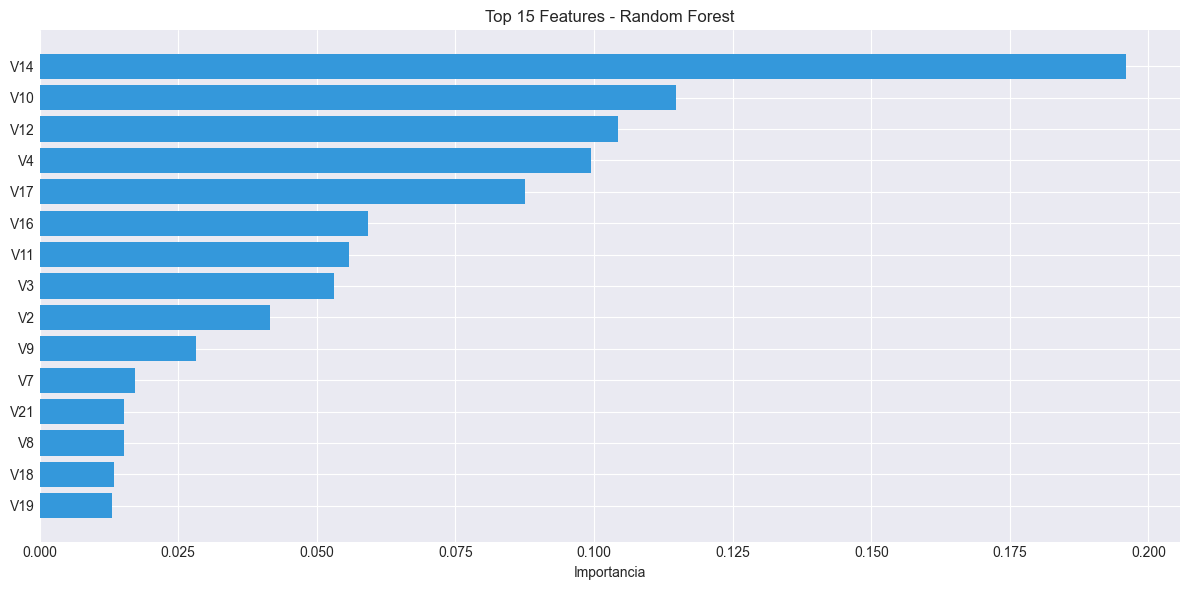

In [22]:
# CELDA 7: Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 TOP 10 FEATURES MÁS IMPORTANTES")
print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(12, 6))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='#3498db')
plt.xlabel('Importancia')
plt.title('Top 15 Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'feature_importance.png', dpi=300)
plt.show()

📊 COMPARACIÓN DE MODELOS
             Modelo precision recall f1_score roc_auc
Logistic Regression    0.0549 0.8734   0.1034  0.9689
      Random Forest    0.4923 0.8101   0.6124  0.9688

🏆 MEJOR MODELO: Random Forest


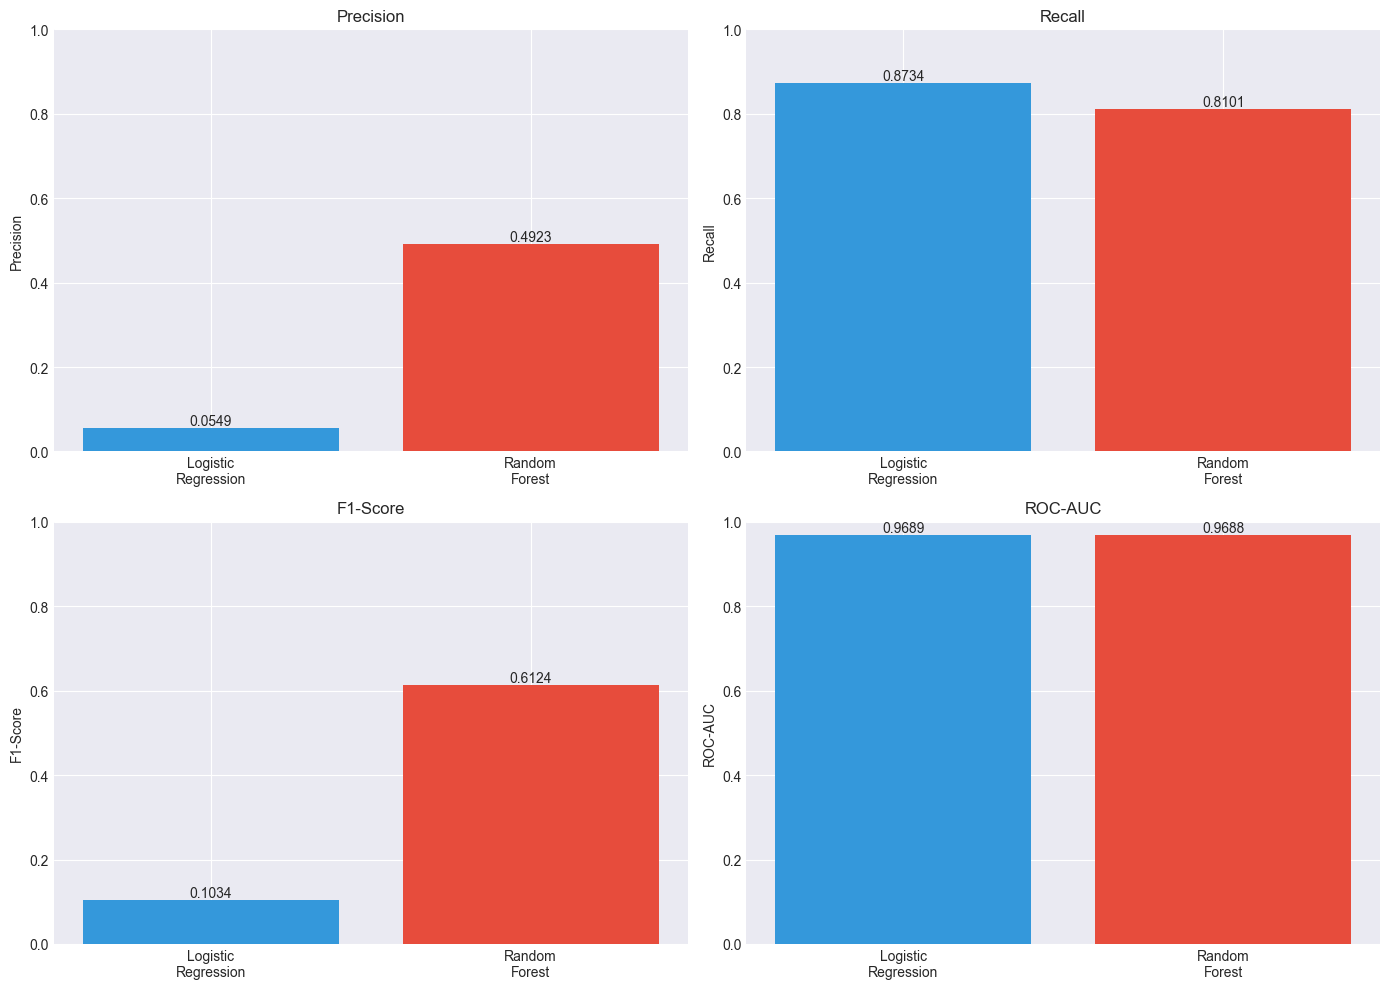

In [23]:
# CELDA 8: Comparación de Modelos
comparison_df = pd.DataFrame([
    {'Modelo': 'Logistic Regression', **{k: f"{v:.4f}" for k, v in lr_metrics.items() if k in ['precision', 'recall', 'f1_score', 'roc_auc']}},
    {'Modelo': 'Random Forest', **{k: f"{v:.4f}" for k, v in rf_metrics.items() if k in ['precision', 'recall', 'f1_score', 'roc_auc']}}
])

print("="*60)
print("📊 COMPARACIÓN DE MODELOS")
print("="*60)
print(comparison_df.to_string(index=False))

best_model_name = 'Random Forest' if rf_metrics['f1_score'] > lr_metrics['f1_score'] else 'Logistic Regression'
print(f"\n🏆 MEJOR MODELO: {best_model_name}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_to_plot = ['precision', 'recall', 'f1_score', 'roc_auc']
titles = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    values = [lr_metrics[metric], rf_metrics[metric]]
    bars = ax.bar(['Logistic\nRegression', 'Random\nForest'], values, color=['#3498db', '#e74c3c'])
    ax.set_ylabel(title)
    ax.set_title(f'{title}')
    ax.set_ylim([0, 1])
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'model_comparison.png', dpi=300)
plt.show()

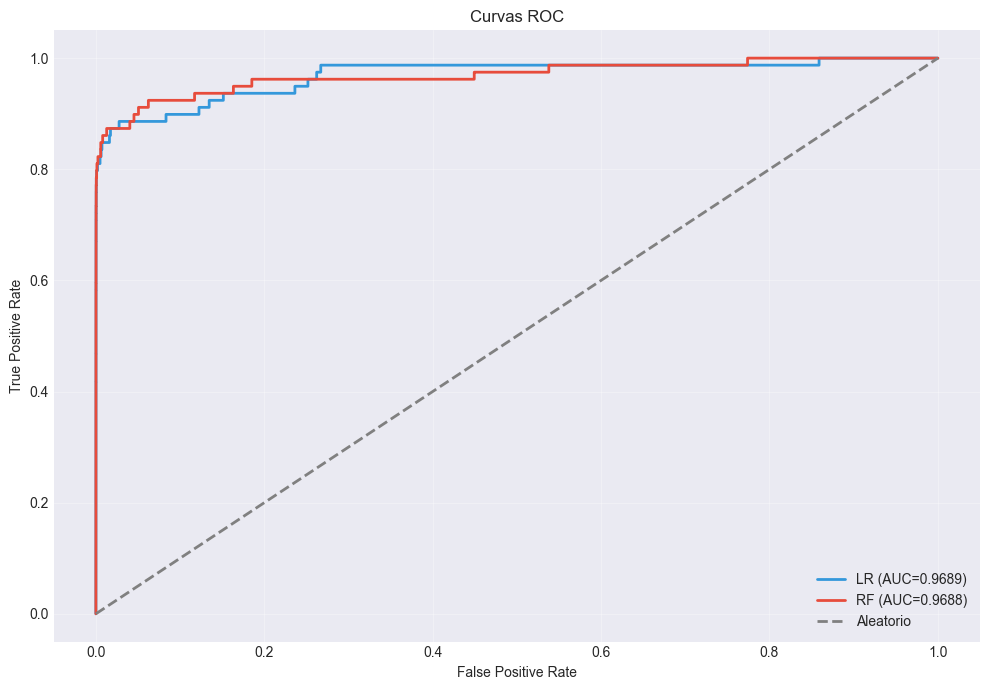

In [24]:
# CELDA 9: Curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_pred_proba_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, color='#3498db', lw=2, label=f'LR (AUC={lr_metrics["roc_auc"]:.4f})')
plt.plot(fpr_rf, tpr_rf, color='#e74c3c', lw=2, label=f'RF (AUC={rf_metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'gray', lw=2, linestyle='--', label='Aleatorio')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'roc_curves.png', dpi=300)
plt.show()

In [25]:
# CELDA 10: Guardar Modelos
print("="*60)
print("💾 GUARDANDO MODELOS")
print("="*60)

joblib.dump(lr_model, MODELS_PATH / 'logistic_regression.pkl')
print("✅ logistic_regression.pkl")

joblib.dump(rf_model, MODELS_PATH / 'random_forest.pkl')
print("✅ random_forest.pkl")

best_model = rf_model if best_model_name == 'Random Forest' else lr_model
joblib.dump(best_model, MODELS_PATH / 'best_model.pkl')
print(f"\n🏆 best_model.pkl ({best_model_name})")

metrics_summary = pd.DataFrame([lr_metrics, rf_metrics])
metrics_summary.to_csv(MODELS_PATH / 'model_metrics.csv', index=False)
print("\n✅ Métricas guardadas")

💾 GUARDANDO MODELOS
✅ logistic_regression.pkl
✅ random_forest.pkl

🏆 best_model.pkl (Random Forest)

✅ Métricas guardadas


In [26]:
# CELDA 11: Evaluación Final en Test Set
print("="*60)
print("🧪 EVALUACIÓN FINAL - TEST SET")
print("="*60)

y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba, f"{best_model_name} (TEST)")

print("\n📊 Val vs Test:")
val_m = rf_metrics if best_model_name == 'Random Forest' else lr_metrics
comp = pd.DataFrame([
    {'Set': 'Validation', 'Precision': f"{val_m['precision']:.4f}", 'Recall': f"{val_m['recall']:.4f}", 'F1': f"{val_m['f1_score']:.4f}"},
    {'Set': 'Test', 'Precision': f"{test_metrics['precision']:.4f}", 'Recall': f"{test_metrics['recall']:.4f}", 'F1': f"{test_metrics['f1_score']:.4f}"}
])
print(comp.to_string(index=False))

🧪 EVALUACIÓN FINAL - TEST SET

📊 MÉTRICAS - Random Forest (TEST)

🎯 Precision: 0.4693 (46.93%)
🎯 Recall:    0.8571 (85.71%)
🎯 F1-Score:  0.6065
🎯 ROC-AUC:   0.9801

📋 Matriz de Confusión:
   TN=56,769 FP=95
   FN=14 TP=84

📊 Val vs Test:
       Set Precision Recall     F1
Validation    0.4923 0.8101 0.6124
      Test    0.4693 0.8571 0.6065


## 🎉 RESUMEN FINAL

### ✅ Logros:

1. ✅ Entrenamos 2 modelos (Logistic Regression y Random Forest)
2. ✅ Evaluamos con métricas apropiadas para datos desbalanceados
3. ✅ Comparamos modelos sistemáticamente
4. ✅ Seleccionamos el mejor modelo
5. ✅ Validamos en Test Set
6. ✅ Guardamos modelos para producción

### 🎯 Próximos Pasos:

- Ajuste de hiperparámetros (GridSearch)
- Probar más modelos (XGBoost, LightGBM)
- Feature engineering adicional
- Deployment en producción

### 💡 Conceptos Aprendidos:

1. Métricas para datos desbalanceados
2. Trade-off Precision vs Recall
3. Logistic Regression vs Random Forest
4. Feature Importance
5. Evaluación rigurosa (Train → Val → Test)